In [1]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

####Generate a mixing matrix for use in metapopulation code###
* Size will be npatchxnpatch
* Dispersion kernel defined by:  
$ p(d) = \frac{1}{N} \exp\left(-(d/\alpha)^c\right)$  
$\alpha$ sets the length scale of dispersion, and $c$ adjusts the 'tail fatness.' Higher $c$ means fatter (skinnier??) tails. $d$ is the distance between the points.
* Normalization constant is:  
$N = \frac{2\pi \alpha^2 \Gamma(2/c)}{c}$


#### Doing 1/r^n instead ####

Because it was kind of hard to interpret the kernel above, we're just going to do a 1/r^n function for the mixing matrix


In [2]:
#Set constants for the matrix you want.
n = 20         #size of an edge (even numbers make the movie easier)
npatch = n*n   #npatch is nxn - the matrix is npatchxnpatch
alpha = 1.     #length scale
cinj = 0.5        #tail weight (lower c -> higher tail weight)

In [3]:
def distance(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
def kernel(d,a,c):
    N = 2.*np.pi*a*sp.special.gamma(1./c)/c
    pofd = np.exp(-((d/a)**c))
    return pofd/N

/Users/laurasampson/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


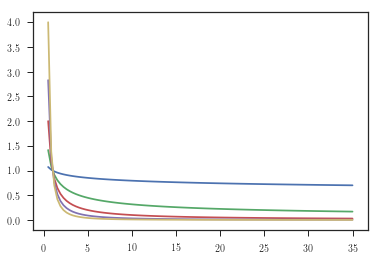

In [4]:
dist = np.linspace(0.5,35,100) #For normalization purposes, should neighboring cells be 'zero'? (Yes.)
dx = dist[1]-dist[0]

ctest = [0.1,0.5,1.,1.5,2.]
alpha = 5.
for cinj in ctest:
    k = kernel(dist,alpha,cinj)
    k = 1./(dist**cinj)
    #k /= sum(k*dx)   #Normalize
    plt.plot(dist,k)
    #plt.ylim(0,0.4)

In [9]:
#For a given alpha and c, you want to output an npatchxnpatch matrix with k giving the values of each cell. 
#You should only have to calculate k once - it just gets 'shifted' for each new row. The trick is to calculate 
#the distance between each point in the row.

#Not using the complicated kernel. Do 5 c's between 0.1 and 5.0 to start. We are explicitly setting the value
#of the mixing matrix that corresponds to the 'self mixing' to zero, so we don't have to keep track of it in the 
#metapop code.
cinj = 10.
alpha = 10.
mixmat = np.zeros([n,n])
mixmat += 0.00001
betamat = []
for istar in range(n):
    for jstar in range(n):
        for i in range(n):
            for j in range(n):
                dist = np.abs(np.sqrt((i-istar)**2+(j-jstar)**2))+0.5 #scaled by a bit so that min distance isn't 1.0
                if dist<=0:
                    dist = 0.05
                if (i==istar)&(j==jstar):
                    dist = 0.05
                #k = kernel(dist,alpha,cinj)
                k = 1./dist**cinj
                mixmat[i,j] = k
                
                #To generate a diagonal mixing matrix:   
                '''
                mixmat[i,j] = 0.
                '''
        #for diagonal:        
        #mixmat[istar,jstar] = 1.
        #The way we're going to code it up now, [istar,jstar] should always be zero - even when using a 'diagonal'
        #mixing matrix, becuase now the within-patch dynamics are completely separate.
        mixmat[istar,jstar] = 0.
        
        mixvec = mixmat.flatten()
        betamat.append(mixvec)
betamat = np.array(betamat)

In [10]:
#Need to scale so that the population mixing isn't explicitly affecting R0. Set maximum eigenvalue to 1.0.
'''
R0 = 1.
gamma = 1.                  #Number of timesteps to recovery. Our timesteps are two weeks long, so this is just one.
maxeig = R0*gamma

for i in range(n*n):
    trial = betamat[i,:].copy()                       #mixing matrix associated with individual cell
    trial = trial.reshape(n,n)
    scale = np.real(np.max(np.linalg.eigvals(trial)))
    betamat[i,:] *= 1./(scale*n*n)                          #Scale so the maximum eigenvalue *of each matrix* is 1.0

print scale
trial = betamat[209,:].copy()                 #check that this worked.
trial = trial.reshape(n,n)
print np.max(np.linalg.eigvals(trial)) 
'''

'\nR0 = 1.\ngamma = 1.                  #Number of timesteps to recovery. Our timesteps are two weeks long, so this is just one.\nmaxeig = R0*gamma\n\nfor i in range(n*n):\n    trial = betamat[i,:].copy()                       #mixing matrix associated with individual cell\n    trial = trial.reshape(n,n)\n    scale = np.real(np.max(np.linalg.eigvals(trial)))\n    betamat[i,:] *= 1./(scale*n*n)                          #Scale so the maximum eigenvalue *of each matrix* is 1.0\n\nprint scale\ntrial = betamat[209,:].copy()                 #check that this worked.\ntrial = trial.reshape(n,n)\nprint np.max(np.linalg.eigvals(trial)) \n'

In [11]:
for i in range(n*n):
    trial = betamat[i,:].copy()
    scale = np.sum(trial)
    scale = np.sum(scale)
    betamat[i,:] *= 1./scale

trial = betamat[209,:].copy()
trial = trial.reshape(n,n)
print np.sum(trial)

1.0


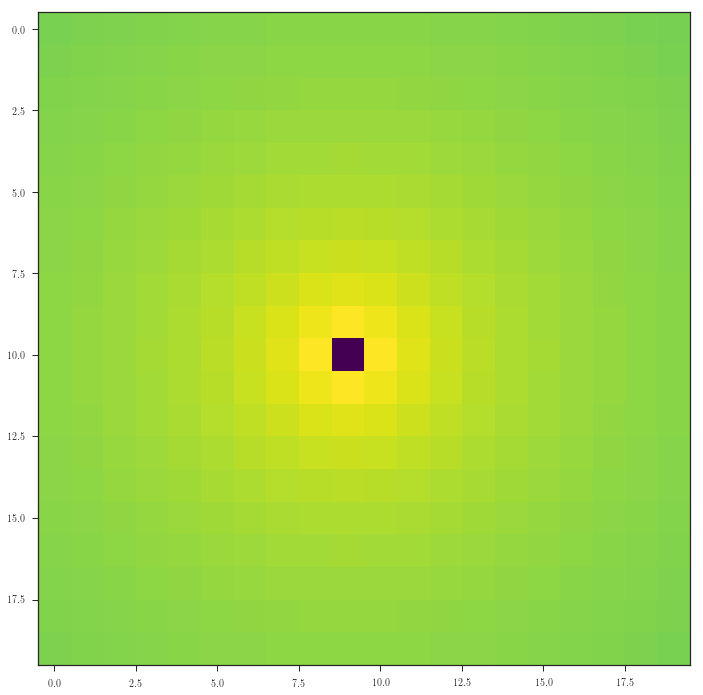

In [62]:
plt.figure(figsize=(12,12))
plt.imshow(trial,cmap='viridis',interpolation='none')

In [63]:

filename = 'mixingMatrices/BetaMc0.1_norm.hpp'
with open(filename,"w") as f:
    f.write("static std::array<std::array<float, nptch>, nptch> sbetaMatrix = {{\n")
    for row in betamat:
        f.write("{{")
        for i in range(npatch-1):
            f.write(str(row[i])+",")
        f.write(str(row[npatch-1])+"}},\n")
    f.write("}};")
    

In [37]:
popmat = np.ones([n,n])*2.

In [53]:
one = np.sum(trial*popmat,axis=1)
print one
print np.sum(one)

[  2.25222612e-04   3.45387286e-04   5.51959693e-04   9.28755815e-04
   1.67046974e-03   3.28649368e-03   7.34212395e-03   1.98922389e-02
   7.45498845e-02   5.44476889e-01   6.93686371e-01   5.44476889e-01
   7.45498845e-02   1.98922389e-02   7.34212395e-03   3.28649368e-03
   1.67046974e-03   9.28755815e-04   5.51959693e-04   3.45387286e-04]
2.0
